<a id='toc'></a>

# Table Of Contents

1. [Importing Packages](#imports)
2. [Import and Clean Data](#data)
3. [Exploratory Data Analysis](#eda)
4. [Data Visualization](#viz)
5. [Data Preprocessing](#preprocessing)
6. [Model Training](#model)
7. [Predictions](#predictions)

<a id='imports'></a>

## 1. Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm_notebook
from tqdm.keras import TqdmCallback
from IPython.display import clear_output



from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence

from sklearn import metrics


import random
from math import floor, ceil

[top](#toc)

<a id='data'></a>

## 2. Import and Clean Data

In [2]:
def read_all_sheets(filename):
    '''
    Read all sheets at once in an excel file and output to a dictionary
    '''
    workbook = pd.ExcelFile(filename)
    raw_data = {}
    for sheet in tqdm_notebook(workbook.sheet_names):
        raw_data[sheet] = pd.read_excel(
                    filename, 
                    sheet_name=sheet,
                    index_col=0,
                    parse_dates=True)
        
    return raw_data     

In [3]:
# 2018 Outside Data
filename = '2018_10m.xlsx'
raw_data_2018 = read_all_sheets(filename)

  0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
# 2019 Outside Data
filename = '2019_10m.xlsx'
raw_data_2019 = read_all_sheets(filename)

  0%|          | 0/12 [00:00<?, ?it/s]

In [5]:
# Outside Data - Open
filename = 'Open.xlsx'
raw_data_open = read_all_sheets(filename)

  0%|          | 0/18 [00:00<?, ?it/s]

In [6]:
# Inside Data
filename = 'GSS.xlsx'
raw_data_inside = read_all_sheets(filename)

  0%|          | 0/18 [00:00<?, ?it/s]

### What sheets are in the excel files?

In [7]:
raw_data_2018.keys()

dict_keys(['09-2018', '10-2018', '11-2018', '12-2018', 'DLI'])

In [8]:
raw_data_2019.keys()

dict_keys(['01-2019', '02-2019', '03-2019', '04-2019', '05-2019', '06-2019', '07-2019', '08-2019', '09-2019', '10-2019', '11-2019', 'DLI'])

In [9]:
raw_data_open.keys()

dict_keys(['9-24-19---Open', 'Sheet1', '9-18', '10-18', '11-18', '12-18', '1-19', '2-19', '3-19', '4-19', '5-19', '6-19', '7-19', '8-19', '9-19', '10-19', '11-19', 'Chart'])

In [10]:
raw_data_inside.keys()

dict_keys(['9-24-19---GSS', 'Sheet1', '9-18', '10-18', '11-18', '12-18', '1-19', '2-19', '3-19', '4-19', '5-19', '6-19', '7-19', '8-19', '9-19', '10-19', '11-19', 'Chart'])

### Remove extra sheets

In [11]:
del raw_data_2018['DLI']
del raw_data_2019['DLI']
del raw_data_inside['9-24-19---GSS']
del raw_data_inside['Sheet1']
del raw_data_inside['Chart']
del raw_data_open['9-24-19---Open']
del raw_data_open['Sheet1']
del raw_data_open['Chart']

### Combine all the sheets into one dataframe

In [12]:
# Combine outside sheets into one dataframe
data_2018 = pd.concat(raw_data_2018.values())
data_2019 = pd.concat(raw_data_2019.values())
outside_data = pd.concat([data_2018, data_2019])

# Rename columns on outside data
columns = ['temp_out', 'hum', 'ws', 'wd', 'sol']
outside_data = outside_data.set_axis(columns, axis=1)
outside_data = outside_data.drop(['wd', 'temp_out'], axis=1)

# Combine inside sheets into one dataframe
inside_data = {}
for key in raw_data_inside.keys():
    inside_data[key] = raw_data_inside[key]['Unnamed: 7'].iloc[1:]
inside_data = pd.concat(inside_data.values())
inside_data.name = 'temp_in'

# Combine open sheets into one dataframe
open_data = {}
for key in raw_data_open.keys():
    open_data[key] = raw_data_open[key]['Unnamed: 7'].iloc[1:]
open_data = pd.concat(open_data.values())
open_data.name = 'temp_open'

tunnel_data = pd.concat([inside_data, open_data], axis=1)

tunnel_data = tunnel_data.dropna()

# Remove missing data from each and combine
missing = pd.date_range(
    start = tunnel_data.index[0], end = tunnel_data.index[-1], freq='10min').difference(tunnel_data.index)
outside_data = outside_data.loc[tunnel_data.index[0]:tunnel_data.index[-1]]
outside_data = outside_data.drop(missing)
missing = tunnel_data.index.difference(outside_data.index)
tunnel_data = tunnel_data.drop(missing)
df = pd.concat([tunnel_data, outside_data], axis=1)

# Trim to only have full days at start
for i in df.index:
    if i.hour == 0 and i.minute == 0:
        start = i 
        break
    
for i in df.index[::-1]:
    if i.hour == 23 and i.minute == 50:
        stop = i 
        break   
    
df = df[start:stop]

# Remove bad data and switch type to numeric
missing = pd.date_range(
    start = df.index[0], end = df.index[-1], freq='10min').difference(
    df[pd.to_numeric(df.temp_in.replace('.','')).notnull()].index)
missing_days_num = []
missing_days_str = []

for i in missing:
    if i.dayofyear not in missing_days_num:
        missing_days_num.append(i.dayofyear)
        if i.month < 10 and i.day < 10:
            missing_days_str.append(f'{i.year}-0{i.month}-0{i.day}')            
        elif i.day < 10:
            missing_days_str.append(f'{i.year}-{i.month}-0{i.day}')
        elif i.month < 10:
            missing_days_str.append(f'{i.year}-0{i.month}-{i.day}')
        else:
            missing_days_str.append(f'{i.year}-{i.month}-{i.day}')
        
for i in missing_days_str:
    start = f'{i} 00:00:00'
    stop = f'{i} 23:50:00'
    df = df.drop(df.loc[start:stop].index)

df.temp_in = pd.to_numeric(df.temp_in)
df.temp_open = pd.to_numeric(df.temp_open)

[top](#toc)

<a id='eda'></a>

## 3. Exploratory Data Analysis

In [13]:
df.head()

,temp_in,temp_open,hum,ws,sol
2018-09-02 00:00:00,21.6,21.6,92.0,1.78816,0.0
2018-09-02 00:10:00,21.6,21.6,92.0,2.90576,0.0
2018-09-02 00:20:00,21.6,21.6,92.0,3.57632,0.0
2018-09-02 00:30:00,21.6,21.6,92.0,2.68224,0.0
2018-09-02 00:40:00,21.6,21.8,92.0,1.34112,0.0


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58752 entries, 2018-09-02 00:00:00 to 2019-11-14 23:50:00
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp_in    58752 non-null  float64
 1   temp_open  58752 non-null  float64
 2   hum        58752 non-null  float64
 3   ws         58752 non-null  float64
 4   sol        58752 non-null  float64
 5   day_cos    58752 non-null  float64
 6   day_sin    58752 non-null  float64
 7   month_cos  58752 non-null  float64
 8   month_sin  58752 non-null  float64
dtypes: float64(9)
memory usage: 6.5 MB
None


In [15]:
df.describe()

,temp_in,temp_open,hum,ws,sol
count,58752.000000,58752.000000,58752.00000,58752.000000,58752.000000
mean,12.613734,10.258530,77.14671,1.871176,131.435506
std,10.755259,10.505569,16.19398,1.887238,220.751757
min,-18.300000,-24.233333,19.00000,0.000000,0.000000
25%,3.733333,1.633333,67.00000,0.447040,0.000000
50%,13.633333,11.400000,81.00000,1.341120,0.000000
75%,20.700000,18.800000,91.00000,2.905760,178.000000
max,41.500000,33.600000,99.00000,16.316960,1218.000000


[top](#toc)

<a id='viz'></a>

## 4. Data Visualization

In [16]:
# Plot style and size
sns.set_style('whitegrid') 
plt.rcParams['figure.figsize'] = (20, 10)

### Correlation Heatmap

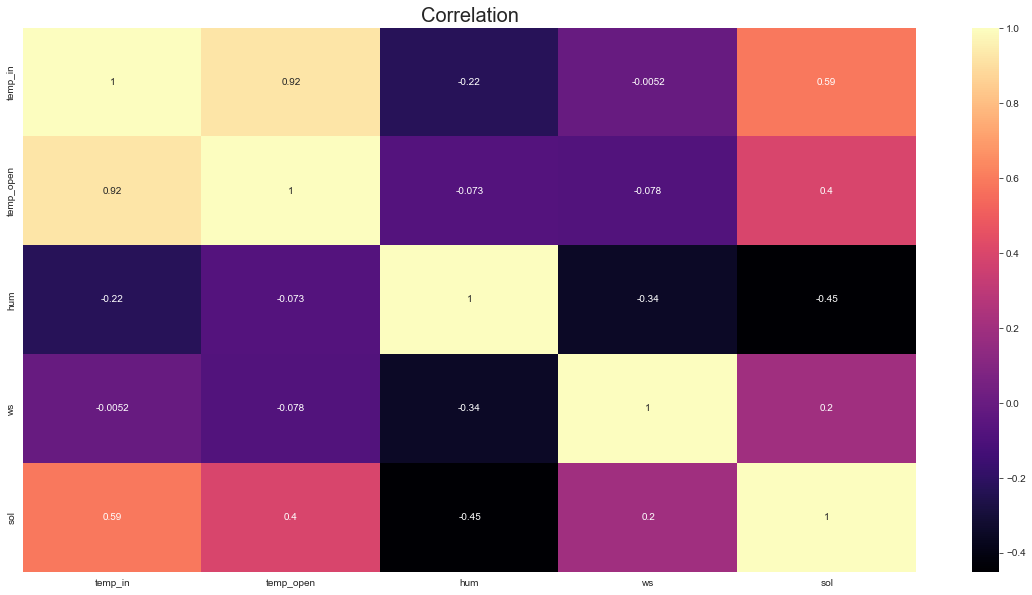

In [17]:
sns.heatmap(df.corr(), annot= True, cmap='magma')
plt.title(f"Correlation", fontsize=20)
plt.show()

### Line plots of all weather parameters

In [18]:
def scatter_df(df, title):
    colors = iter(['orange',
                   'deepskyblue',
                   'crimson',
                   'darkviolet',
                   'gold',
                   'r',
                   'deeppink'])
    for i in df.columns:      
        plot = sns.lineplot(
            x=df.index, y=i, data = df, 
            color=next(colors)
        )

        plt.title(f'{title} {i}', fontsize = 16)

        if i in ['temp_in', 'temp_open']:
            plt.ylabel(f'Temp {chr(176)}C', fontsize = 14)
        elif i in 'hum':
            plt.ylabel('RH %', fontsize = 14)
        elif i in 'ws':
            plt.ylabel('Wind Speed m/s', fontsize = 14)
        elif i in 'sol':
            plt.ylabel('Solar Radiation W/m\u00b2', fontsize = 14)

        #plt.ylabel(f'{i}', fontsize = 14)
        plt.xlabel('Time', fontsize = 14)


        plt.xticks(df.index, fontsize = 12, rotation=90)
        minute = mdates.HourLocator(interval=2)
        m_fmt = mdates.DateFormatter("%H:%M")
        plot.xaxis.set_major_locator(minute)
        plot.xaxis.set_major_formatter(m_fmt)

        if "Wind Direction" in i:
            plt.yticks(range(0,361,30),fontsize = 12)
        else:
            plt.yticks(fontsize = 12)

        plt.show()




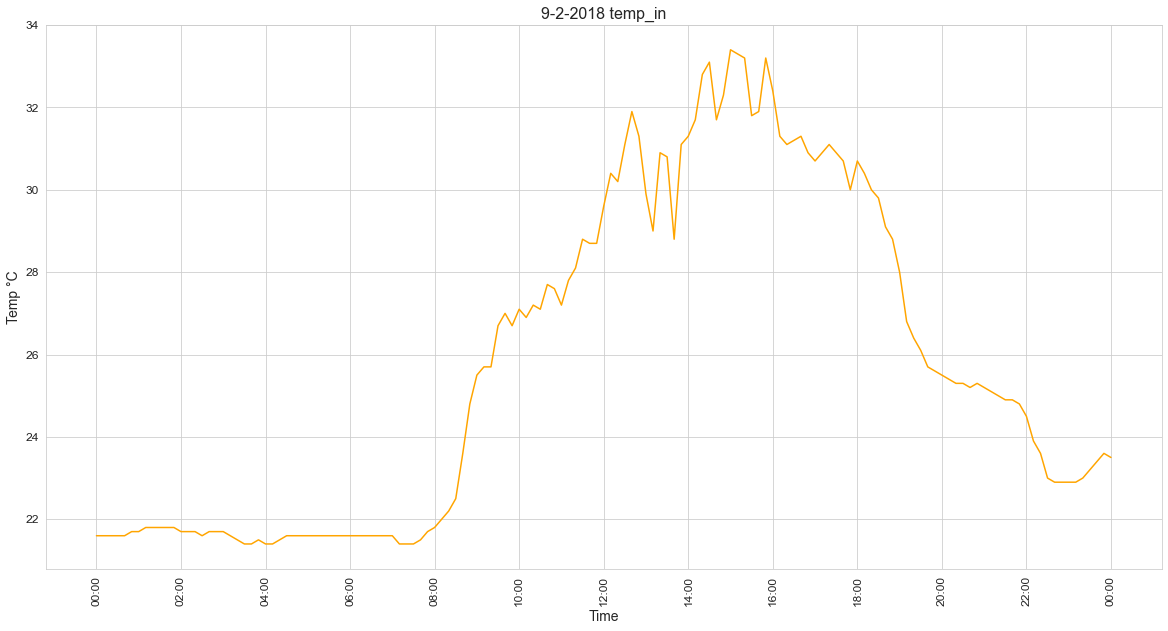

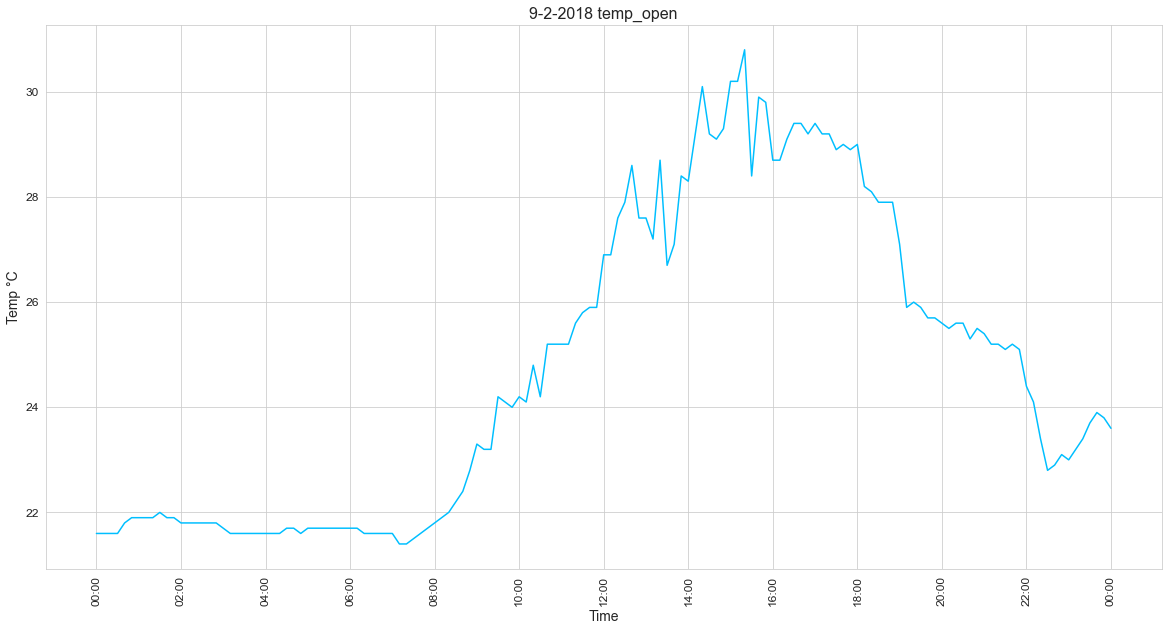

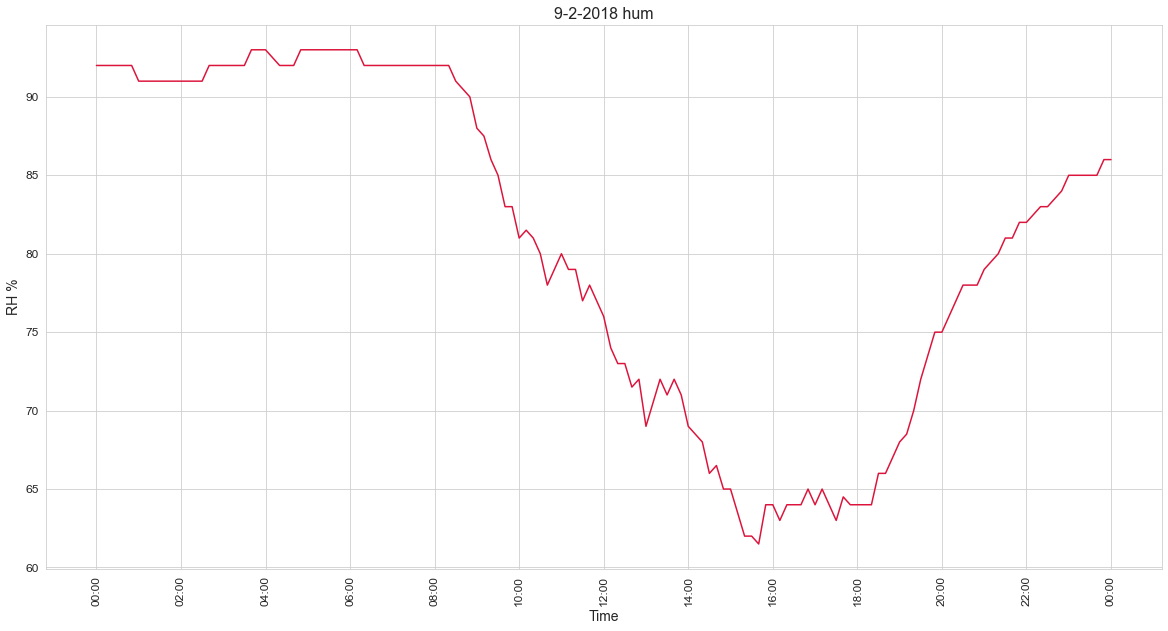

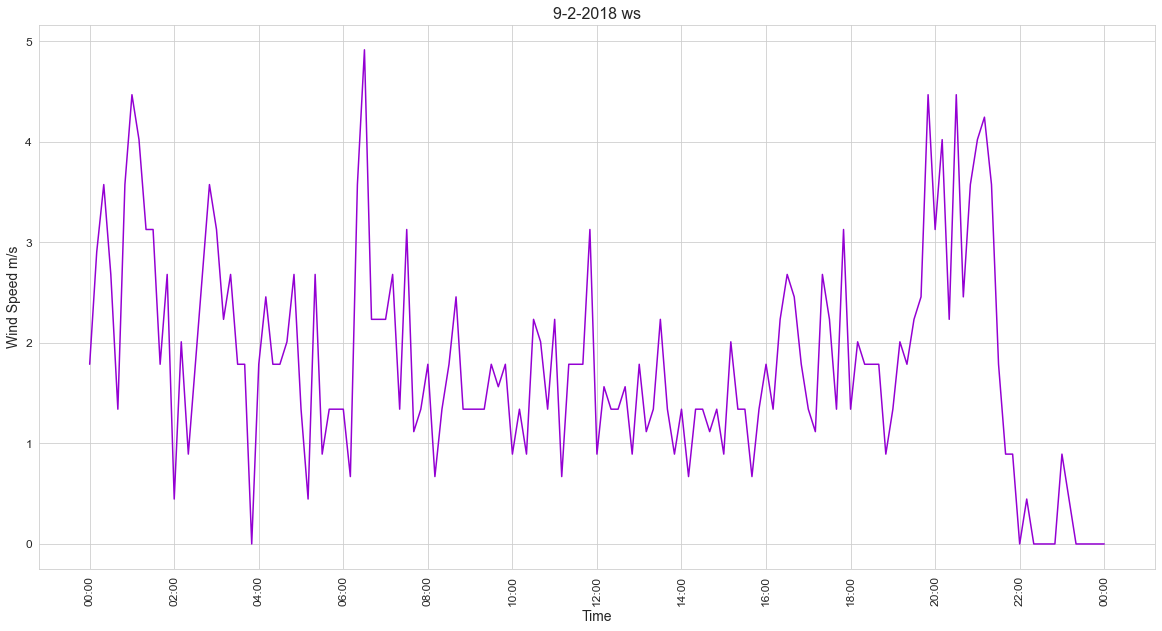

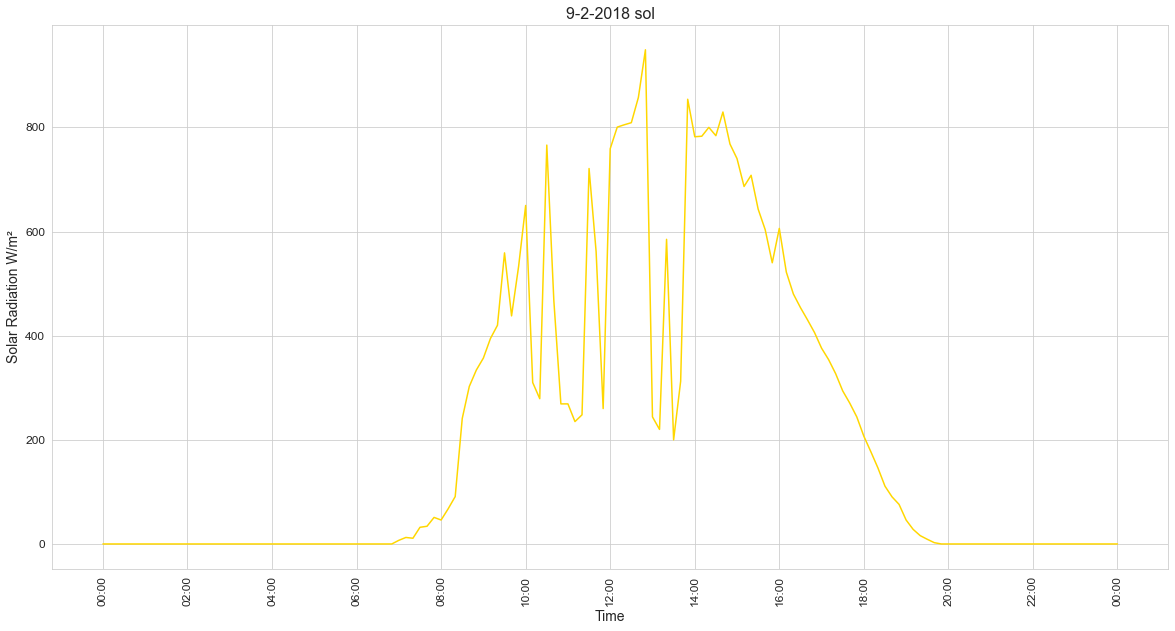

In [19]:
# Line plots for first day in dataset, 9/2/2018
start = df.index[0]
stop = df.index[144]

scatter_df(df[start:stop], f'{start.month}-{start.day}-{start.year}')

### Some days vents are opened, other days they are closed. When vents are open outside wind can ventilate the trapped heat caused by solar radiation. Notice below the large difference between the inside and outside temperature when the vents are closed.

### Typically, the vents stay closed during the winter and stay open during the summer. Since this dataset was not labeled, we'll have to take our best guess to seperate the data.


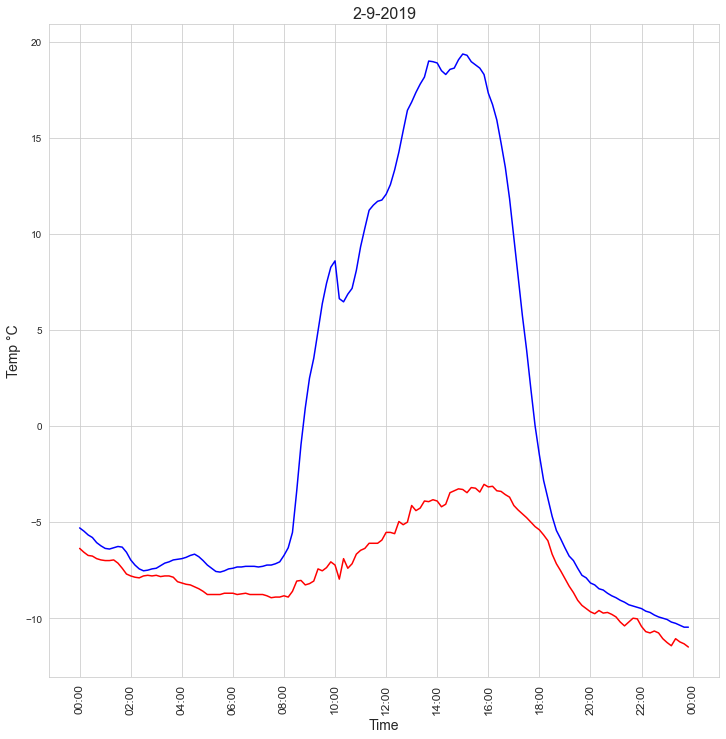

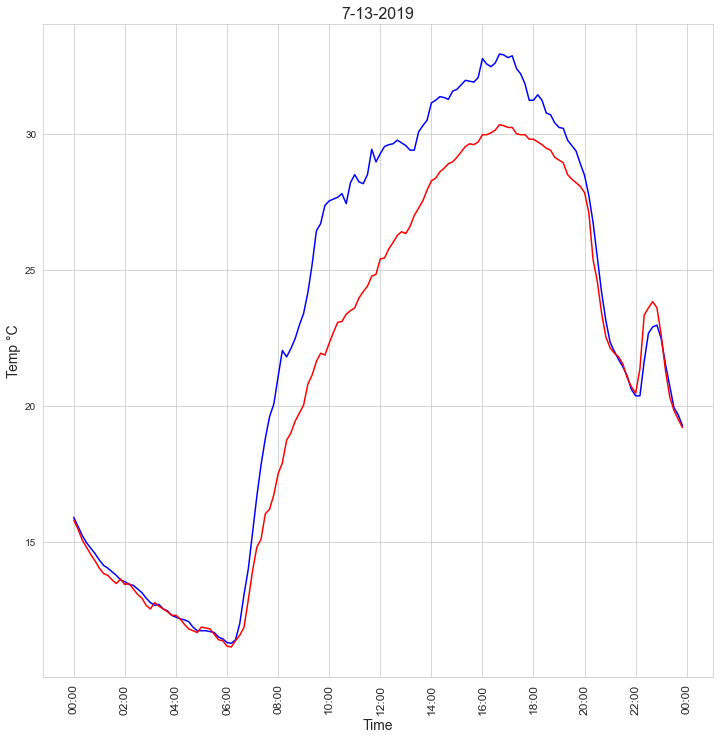

In [20]:
# 2/9/19 (closed vents) and 7/13/19 (open vents)
for i in [153, 292]:
    
    plt.figure(figsize=(12,12))

    # Plot 24 hours
    start = 144 * i
    stop = start+144

    # Inside Temperature
    plot = sns.lineplot(
                    x=df.index[start:stop], y ='temp_in',
                    data = df.iloc[start:stop],
        color='blue'
                )

    # Outside Temperature
    plot = sns.lineplot(
                    x=df.index[start:stop], y ='temp_open',
                    data = df.iloc[start:stop],
        color='red'
                )

    
    # Title and Axis Labels
    timestep = df.iloc[start].name

    plt.title(f'{timestep.month}-{timestep.day}-{timestep.year}', fontsize = 16)
    plt.ylabel(f'Temp {chr(176)}C', fontsize = 14)
    plt.xlabel('Time', fontsize = 14)

    plt.xticks(df.index[start:stop], fontsize = 12, rotation=90)
    minute = mdates.HourLocator(interval=2)
    m_fmt = mdates.DateFormatter("%H:%M")
    plot.xaxis.set_major_locator(minute)
    plot.xaxis.set_major_formatter(m_fmt)
    
    plt.show()

### Box plots of outside temperature

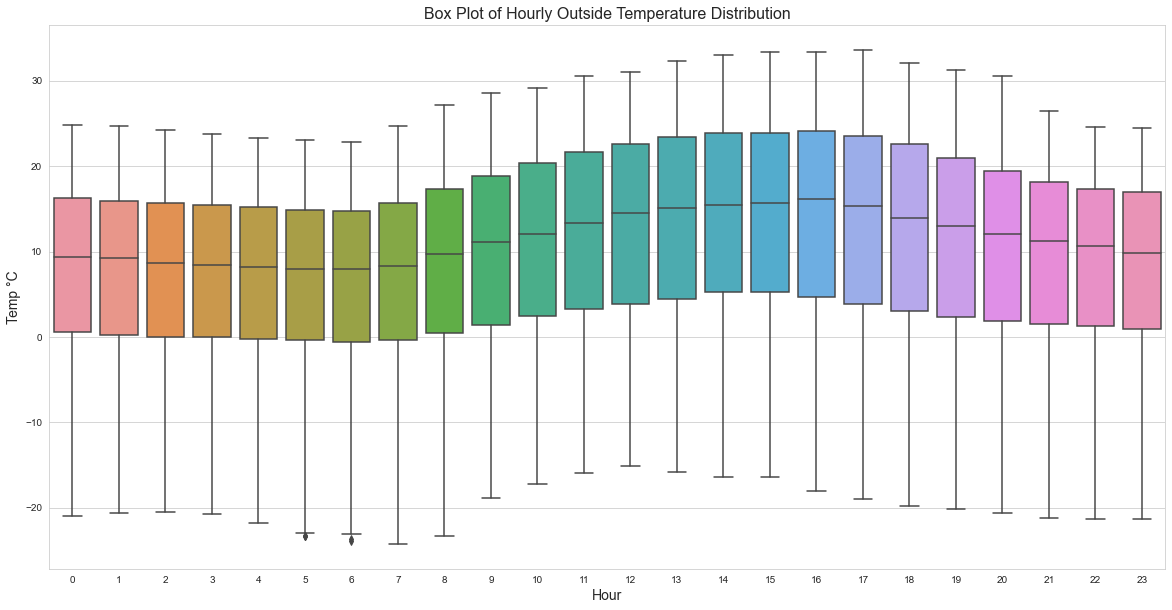

In [21]:
# Box plot of hourly distribution
plot = sns.boxplot(x=df.index.hour, y='temp_open', data=df)
plt.title('Box Plot of Hourly Outside Temperature Distribution', fontsize = 16)
plt.ylabel(f'Temp {chr(176)}C', fontsize = 14)
plt.xlabel('Hour', fontsize = 14)
plt.show()


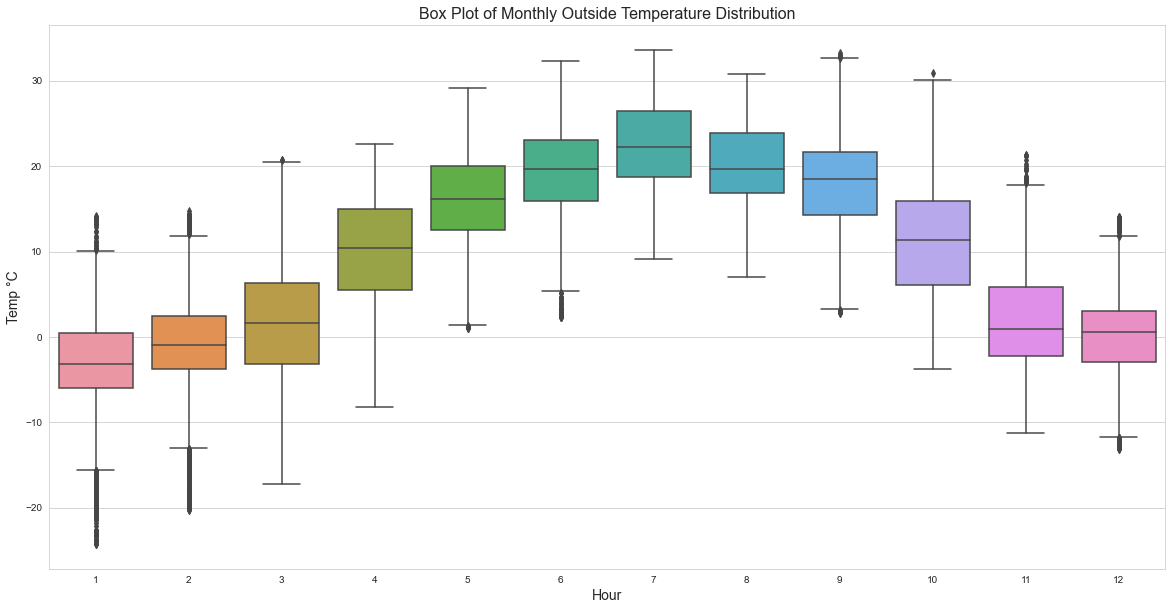

In [22]:
# Box plot of monthly distribution
plot = sns.boxplot(x=df.index.month, y='temp_open', data=df)
plt.title('Box Plot of Monthly Outside Temperature Distribution', fontsize = 16)
plt.ylabel(f'Temp {chr(176)}C', fontsize = 14)
plt.xlabel('Hour', fontsize = 14)
plt.show()

### The cyclical nature of outside temperature may be important for predicting the inside temperature, so a feature will be created to approximate each timestep's place in the daily and yearly temperature cycles.

[top](#toc)

<a id='preprocessing'></a>

# 5. Data Preprocessing

In [23]:
# Creating the cyclical feature for daily and yearly

# Extracting the hour of day
df["hour"] = [x.hour for x in df.index]

# Extracting the timestamp from the datetime object 
df["timestamp"] = [x.timestamp() for x in df.index]

# Seconds in day 
s = 24 * 60 * 60
# Seconds in year 
year = (365.25) * s

# Daily cyclical feature
df["day_cos"] = [np.cos((x/60) % (24*60) * (2 * np.pi / (24*60))) for x in df["timestamp"]]
df["day_sin"] = [np.sin((x/60) % (24*60) * (2 * np.pi / (24*60))) for x in df["timestamp"]]

# Yearly cylical feature
df["month_cos"] = [np.cos((x) * (2 * np.pi / year)) for x in df["timestamp"]]
df["month_sin"] = [np.sin((x) * (2 * np.pi / year)) for x in df["timestamp"]]

df = df.drop(['hour', 'timestamp'], axis=1)

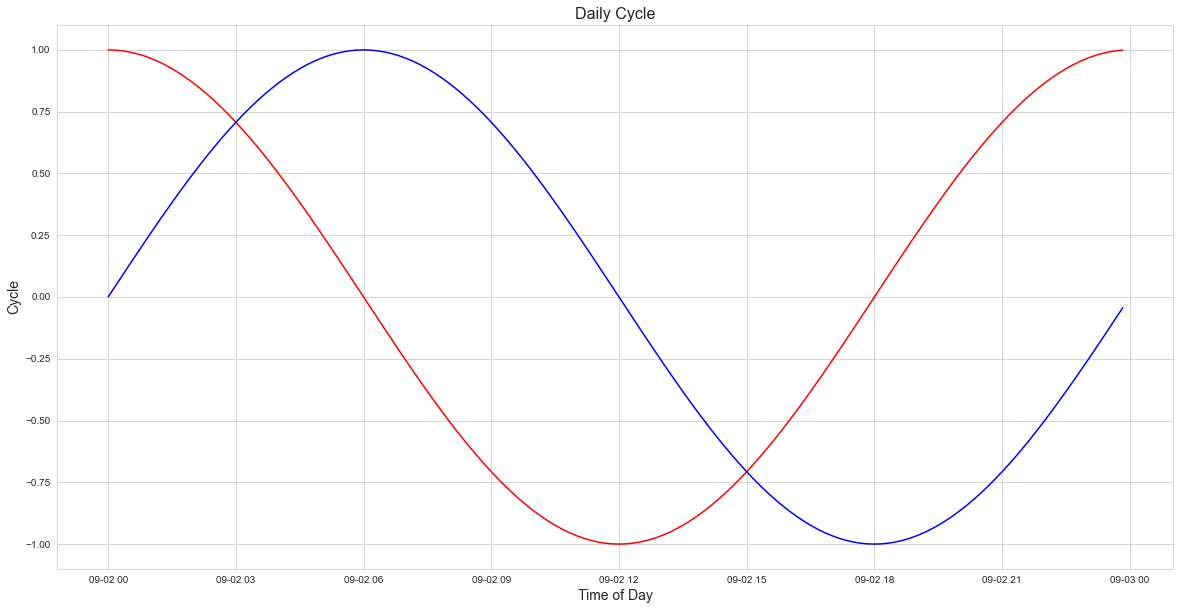

In [24]:
# PLotting daily cyclical feature

plot = sns.lineplot(
                x=df.index[0:144], y='day_cos', data = df[0:144] ,
                color='red', 
            )
plot = sns.lineplot(
                x=df.index[0:144], y='day_sin', data = df[0:144] ,
                color='blue', 
            )

plt.title('Daily Cycle', fontsize = 16)
plt.ylabel('Cycle', fontsize = 14)
plt.xlabel('Time of Day', fontsize = 14)

plt.show()

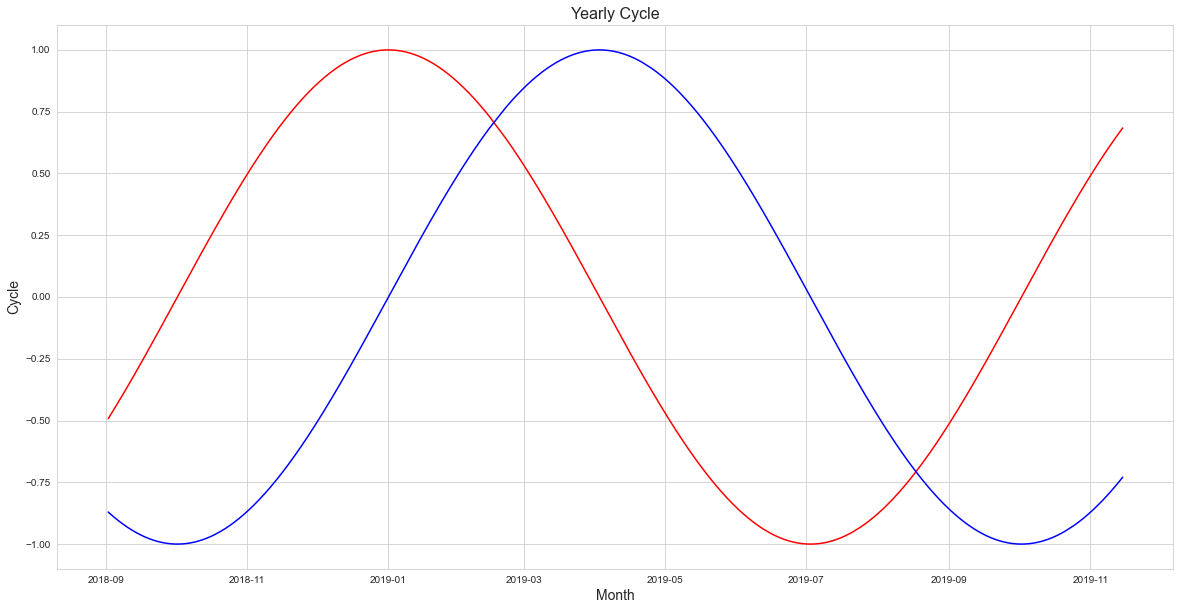

In [25]:
# Plotting yearly cylical feature

plot = sns.lineplot(
                x=df.index, y='month_cos', data = df,
                color='red', 
            )

plot = sns.lineplot(
                x=df.index, y='month_sin', data = df,
                color='blue', 
            )

plt.title('Yearly Cycle', fontsize = 16)
plt.ylabel('Cycle', fontsize = 14)
plt.xlabel('Month', fontsize = 14)

plt.show()

### Create sequences of our data as input for our LSTM model

In [26]:
def create_sequences(ts, lag=1, n_ahead=1, target_index=0):
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1] - 1
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag), target_index+1:])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to LSTM input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [38]:
# Variables for model

# Only days with open vents
start = 252*144 # 6/1/19
stop = 366*144  # 9/30/19
ts = df.iloc[start:stop].copy()
lag = 12
n_ahead = 1
train_size = 0.8

# Scale data
n = len(ts)
train = ts[:int(n*train_size)]
test = ts[int(n*train_size):]

scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

ts_s = np.concatenate([train,test])

# Create sequences
X, y = create_sequences(ts_s, lag=lag, n_ahead=n_ahead)

# Split into train and test

X_train = X[:int(n*train_size)]
X_test = X[int(n*train_size):]

y_train = y[:int(n*train_size)]
y_test = y[int(n*train_size):]



[top](#toc)

<a id='model'></a>

## 6. Model Training

In [29]:
def compile_and_fit(model, X_train, y_train, X_test, y_test, 
                    shuffle=False,
                    patience=5, MAX_EPOCHS=20, weights=None, monitor='val_loss',
                   learning_rate=1e-4, decay=1e-6, verbose=2):
    
    '''
    Combine early stopping, compile, and fit into one function
    '''
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor,
                                                    patience=patience,
                                                    min_delta=0.0001)
    

    model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])



    history = model.fit(X_train, y_train,
                      epochs=MAX_EPOCHS,
                      validation_data=(X_test, y_test),
                      shuffle=shuffle,
                      verbose=0,
                      callbacks=[early_stopping, TqdmCallback(verbose=verbose)]
                       )
    return history

### Using a recurrent neural network will allow us to see how previous timesteps influence future timesteps

In [39]:
# LSTM model with one LSTM layer and one Dense output layer

model = tf.keras.models.Sequential([
    
    layers.LSTM(4,
             return_sequences=True,
               ),
    layers.Dropout(0.2),
    layers.LayerNormalization(),
    
    layers.Flatten(),
    
    layers.Dense(n_ahead),
])


In [40]:
history = compile_and_fit(model, X_train, y_train, X_test, y_test, 
                          MAX_EPOCHS=1000, 
                          patience=5,
                          shuffle=True,
                          learning_rate=1e-4,
                          decay=1e-6,
                          verbose=1,
                         )

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

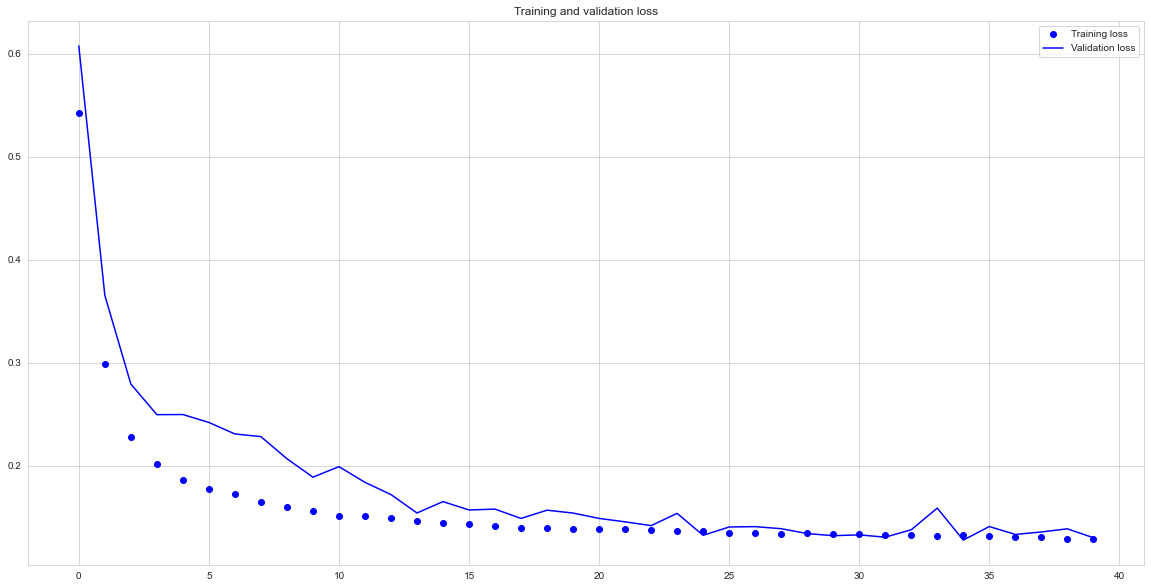

In [41]:
# Plot training loss vs test loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Which features were most important for our predictions?

In [33]:
def perturbation_rank(model,x,y,names):
    '''
    Determines which features are the most important for predictions by 
    randomly shuffling each feature and determining the error --> higher error = higher importance
    '''
    errors = []

    X_saved = np.copy(x)
    
    for i in tqdm_notebook(range(x.shape[2])):

        # Convert to numpy, shuffle, convert back to tensor, predict
        np.random.shuffle(x[:,:,i])
        pred = model.predict(x, verbose=0)[:,0]

        # log_loss requires (classification target, probabilities)
        error = metrics.mean_squared_error(y[:,0], pred)
        errors.append(error)

        # Reset x to saved tensor matrix
        x = X_saved
    
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]
    print(names, errors, importance)
    
    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data,columns = ['name','error','importance'])
    result.sort_values(by=['importance'],ascending=[0],inplace=True)
    result.reset_index(inplace=True,drop=True)
    return result

In [34]:
# Importance of features
names = list(df.columns)
names.remove('temp_in')

rank = perturbation_rank(model, 
                         X_test,
                         y_test,  
                         names
                         )
clear_output(wait=True)
batch_size = 50

for i in range(ceil(len(rank)/batch_size)):
    display(rank[batch_size*i:batch_size*(i+1)])

,name,error,importance
0,temp_open,1.452219,1.000000
1,sol,0.596268,0.410591
2,day_cos,0.573849,0.395153
3,month_sin,0.563391,0.387952
4,month_cos,0.563203,0.387823
5,day_sin,0.562419,0.387282
6,ws,0.058005,0.039942
7,hum,0.035523,0.024461


[top](#toc)

<a id='predictions'></a>

## 7. Predictions

In [53]:
# Predictions from model combined with measured data into dataframe
yhat = model.predict(X_test)
yhat = scaler.inverse_transform(np.concatenate([yhat, X_test[:,-1,:]], axis=1))[:,0]
temp_open = ts.temp_open.iloc[-len(X_test)-1:-1]
measured = ts.temp_in.iloc[-len(X_test)-1:-1]
pred_df = pd.DataFrame({'measured':measured, 'predicted':yhat, 'temp_open':temp_open}, index=ts.index[-len(X_test)-1:-1])

103/103 [==============================] - 1s 6ms/step


In [54]:
# Test data set root mean squared error (RMSE)
print(f'RMSE: {metrics.mean_squared_error(pred_df.measured, pred_df.predicted)**0.5:.3f} {chr(176)}C')

RMSE: 1.164 °C


### Plot several random days of predicted vs measured temperature


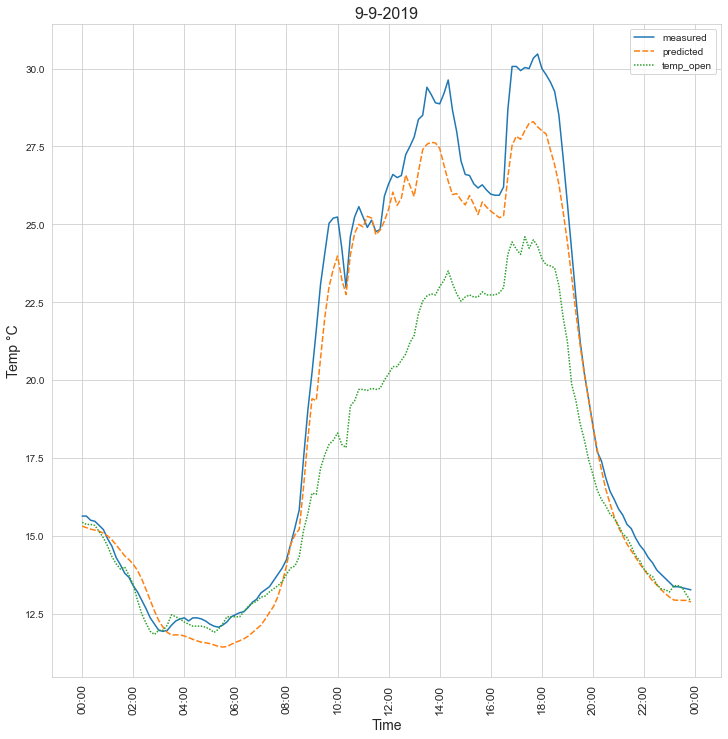

RMSE: 1.105 °C


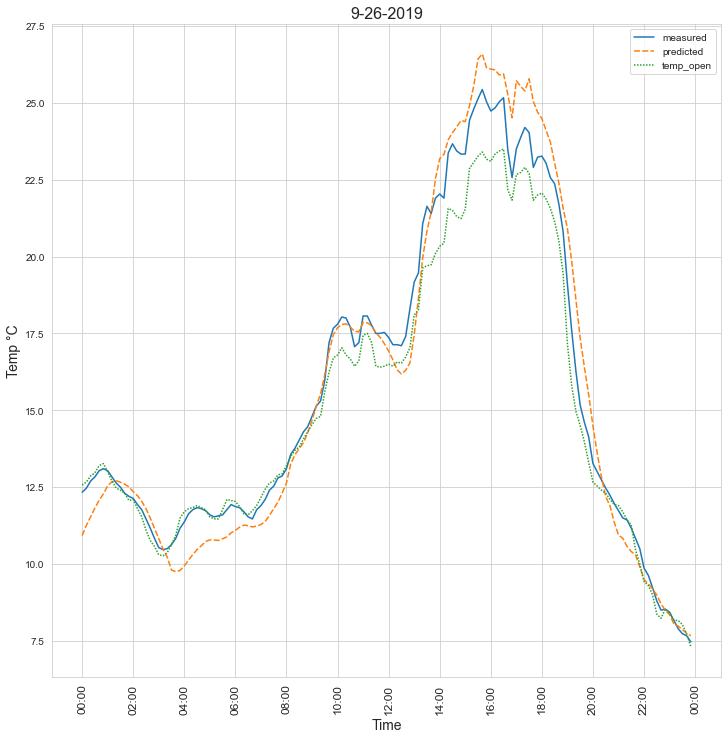

RMSE: 0.924 °C


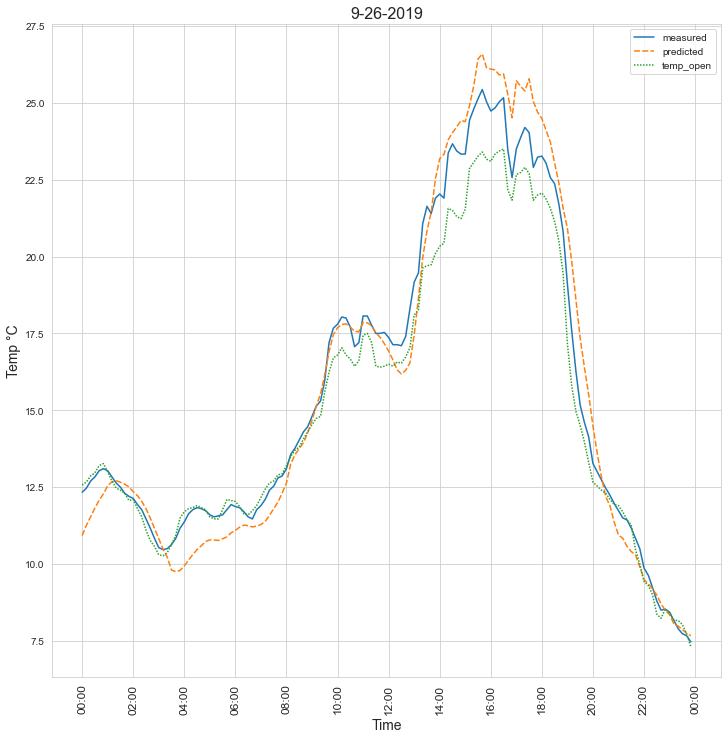

RMSE: 0.924 °C


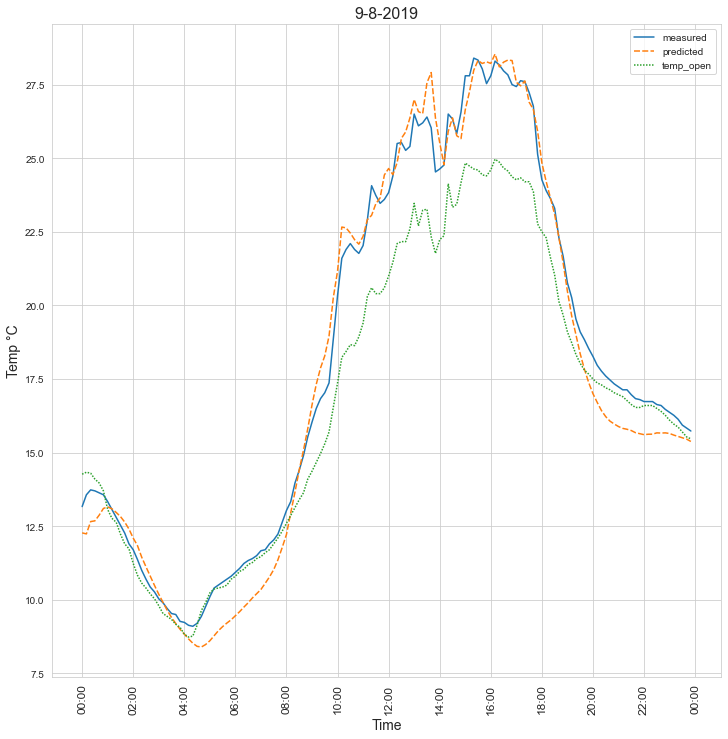

RMSE: 0.865 °C


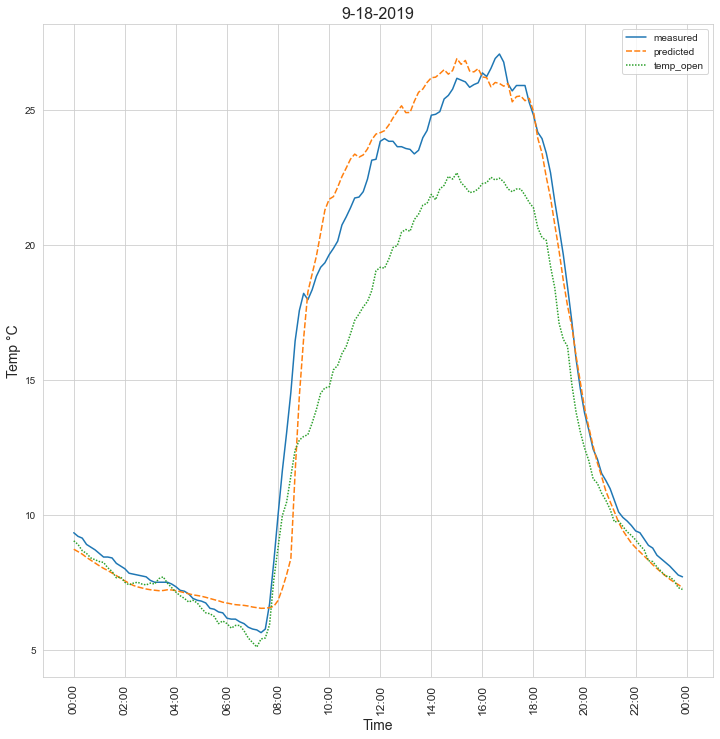

RMSE: 1.265 °C


In [55]:
# Number of days in predictions dataframe
days = floor((len(pred_df))/144)

for i in range(5):
    
    plt.figure(figsize=(12,12))

    # Pick a random day to plot
    rand_day = random.randrange(days-1)
    
    start = 104 + 144 * rand_day
    stop = start+144

    # Plot outside, measured inside, predicted inside temperatures
    plot = sns.lineplot(
                    data = pred_df.iloc[start:stop]
                )

    timestep = pred_df.iloc[start].name

    # Title and Axis Labels
    plt.title(f'{timestep.month}-{timestep.day}-{timestep.year}', fontsize = 16)
    plt.ylabel(f'Temp {chr(176)}C', fontsize = 14)
    plt.xlabel('Time', fontsize = 14)

    plt.xticks(pred_df.index[start:stop], fontsize = 12, rotation=90)
    minute = mdates.HourLocator(interval=2)
    m_fmt = mdates.DateFormatter("%H:%M")
    plot.xaxis.set_major_locator(minute)
    plot.xaxis.set_major_formatter(m_fmt)
    plt.show()
    
    # Print RMSE for the plotted day
    print(f'RMSE: {metrics.mean_squared_error(pred_df.measured[start:stop], pred_df.predicted[start:stop])**0.5:.3f} {chr(176)}C')

### Conclusions:

- Considering that the accuracy of the sensors used for the data collection had an accuracy of &plusmn;1 &deg;C, this model is in good agreement with the measured data
- Additional data labeled with the condition of the vents would be helpful to further train the model
- An alternative model could be constructed based off just vents closed data 



[top](#toc)